In [35]:
import torch
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm
import gc


# 폰트 설정
try:
    plt.rcParams['font.family'] = 'Apple SD Gothic Neo'
except:
    try:
        plt.rcParams['font.family'] = 'NanumGothic'
    except:
        plt.rcParams['font.family'] = 'AppleGothic'

plt.rcParams['axes.unicode_minus'] = False
fm._load_fontmanager(try_read_cache=False)


# 디바이스 설정
if torch.backends.mps.is_available() and torch.backends.mps.is_built():
    device = torch.device("mps") # 맥
elif torch.cuda.is_available():
    device = torch.device("cuda:0") # 윈도우
else:
    device = torch.device("cpu")


# 캐시 지우기 함수
def clean_cache():
    gc.collect()
    if torch.backends.mps.is_available() and torch.backends.mps.is_built():
        torch.mps.empty_cache()
    elif torch.cuda.is_available():
        torch.cuda.empty_cache()

In [36]:
import glob

DATA_PATH = "./data"
TRAIN_NORMAL_PATHS = sorted(glob.glob("./data/train/NORMAL/*.jpeg"))
TRAIN_TARGET_PATHS = sorted(glob.glob("./data/train/PNEUMONIA/*.jpeg"))
VAL_NORMAL_PATHS = sorted(glob.glob("./data/val/NORMAL/*.jpeg"))
VAL_TARGET_PATHS = sorted(glob.glob("./data/val/PNEUMONIA/*.jpeg"))
TEST_NORMAL_PATHS = sorted(glob.glob("./data/test/NORMAL/*.jpeg"))
TEST_TARGET_PATHS = sorted(glob.glob("./data/test/PNEUMONIA/*.jpeg"))

PATHS_LIST = [TRAIN_NORMAL_PATHS, TRAIN_TARGET_PATHS, VAL_NORMAL_PATHS, VAL_TARGET_PATHS, TEST_NORMAL_PATHS, TEST_TARGET_PATHS]
PATHS_DICT = {"TRAIN NORMAL": TRAIN_NORMAL_PATHS,
              "TRAIN TARGET": TRAIN_TARGET_PATHS,
              "VAL NORMAL": VAL_NORMAL_PATHS,
              "VAL TARGET": VAL_TARGET_PATHS,
              "TEST NORMAL": TEST_NORMAL_PATHS,
              "TEST TARGET": TEST_TARGET_PATHS}

print("[데이터 개수]")
for name, path in PATHS_DICT.items():
    print(f"· {name}: {len(path)}개")

[데이터 개수]
· TRAIN NORMAL: 1341개
· TRAIN TARGET: 3875개
· VAL NORMAL: 8개
· VAL TARGET: 8개
· TEST NORMAL: 234개
· TEST TARGET: 390개


1. 사이즈 편차가 심하다.

2. 학습 데이터는 많다.

3. 검증 데이터 개수가 적다.

In [37]:
import os

all_folders = [set(os.listdir("./data/train/NORMAL")), 
                set(os.listdir("./data/train/PNEUMONIA")),
                set(os.listdir("./data/val/NORMAL")),
                set(os.listdir("./data/val/PNEUMONIA")),
                set(os.listdir("./data/test/NORMAL")),
                set(os.listdir("./data/test/PNEUMONIA"))]

count = 0
tmp_set = set()

for folder in all_folders:
    for file_name in folder:
        if ".jpeg" in file_name:
            tmp_set.add(file_name)
            count += 1

print(f"전체 중 중복 파일: {count - len(tmp_set)}개")

전체 중 중복 파일: 0개


In [38]:
import random
import torchvision

rand_index = random.randint(0, len(TRAIN_NORMAL_PATHS))

sample_normal_image = TRAIN_NORMAL_PATHS[rand_index]
sample_normal_image = torchvision.io.read_image(sample_normal_image)[0]

print(f"[샘플 이미지 정보]")
print(f"· 사이즈: {sample_normal_image.shape}")
print(f"· 클래스: {type(sample_normal_image)}")
print(f"· 데이터: {sample_normal_image.dtype}")

[샘플 이미지 정보]
· 사이즈: torch.Size([1507, 1666])
· 클래스: <class 'torch.Tensor'>
· 데이터: torch.uint8


- 텐서 타입

- uint8 타입

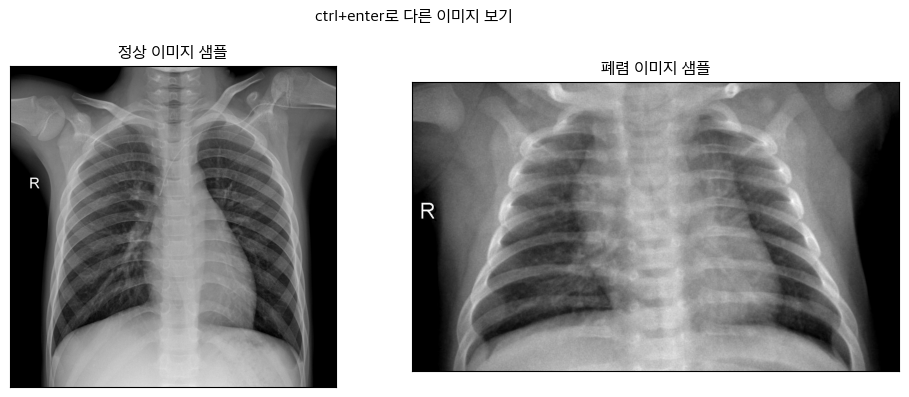

In [39]:
import torchvision
import matplotlib.pyplot as plt

rand_index = random.randint(0, len(TRAIN_NORMAL_PATHS))

sample_normal_image = TRAIN_NORMAL_PATHS[rand_index]
sample_target_image = TRAIN_TARGET_PATHS[rand_index]

sample_normal_image = torchvision.io.read_image(sample_normal_image)
sample_target_image = torchvision.io.read_image(sample_target_image)


# 축 숫자 표기 제거 함수 생성
def remove_ticks(columns=2):
    for num in range(columns):
        axes[num].set_xticks([])
        axes[num].set_yticks([])


# 샘플 이미지 출력
fig, axes = plt.subplots(1, 2, figsize=(10, 4))
remove_ticks()

axes[0].imshow(sample_normal_image[0], cmap="gray")
axes[1].imshow(sample_target_image[0], cmap="gray")

fig.suptitle("ctrl+enter로 다른 이미지 보기")
axes[0].set_title("정상 이미지 샘플")
axes[1].set_title("폐렴 이미지 샘플")

plt.tight_layout()
plt.show()

- 폐렴 환자의 폐 부근이 전반적으로 더욱 뿌옇다는 사실을 알 수 있다.

- 사진 각각의 사이즈가 모두 다르다는 것을 알 수 있다. 이는 사전 학습 모델이 사이즈 조절을 하므로 그대로 진행한다.

In [40]:
# # 사이즈 편차 확인

# max_w = 0
# min_w = 10000000
# max_h = 0
# min_h = 10000000

# print("[사이즈 구성]")

# for name, PATH in PATHS_DICT.items():

#     size_set = set()
#     h_size_set = set()
#     w_size_set = set()

#     for image in PATH:
#         image = torchvision.io.read_image(image)[0]

#         size_set.add(image.shape)
#         h_size_set.add(image.shape[0])
#         w_size_set.add(image.shape[1])
    
#     print(f"· {name}: 총 {len(size_set)} 종류")
#     max_w = max(max_w, max(w_size_set))
#     max_h = max(max_h, max(h_size_set))
#     min_w = min(min_w, min(w_size_set))
#     min_h = min(min_h, min(h_size_set))

# print(f"(최대 W: {max_w}, 최소 W: {min_w}, 최대 H: {max_h}, 최소 H: {min_h})")

함수 선정

- 활성화 함수: 분류에 특화되어 있을 것. 일단 분류니까 시그모이드.

- 손실 함수: 0과 1 사이니까 MSE 또는 RMSLE. 혹은 크로스엔트로피(?)

현재 학습 데이터는 흑백의 1채널로, ResNet 모델의 3채널과 맞지 않으므로, 아래의 두 방향으로 진행한다.

1. 변환기와 conv1의 입력 채널을 3에서 1로 수정한다.

2. 학습 데이터를 3채널로 변환한다.

In [41]:
from torchvision.transforms import v2
from torchvision.transforms import InterpolationMode

# device 설정
ch_1_device = device
ch_3_device = device


# 사전 학습 모델 설정(ResNet152)
ch_1_model = torchvision.models.resnet152(weights='IMAGENET1K_V1')
ch_3_model = torchvision.models.resnet152(weights='IMAGENET1K_V1')


# 기존 변환기 수정(3채널 -> 1채널)  * 참고 자료: https://docs.pytorch.org/vision/main/models/generated/torchvision.models.resnet152.html#torchvision.models.ResNet152_Weights
ch_1_transform = v2.Compose([
        v2.Grayscale(num_output_channels=1), # 입력 채널이 1개이므로 변경.
        v2.Resize(256, interpolation=InterpolationMode.BILINEAR),
        v2.CenterCrop(224),
        v2.ToImage(),
        v2.ToDtype(torch.float32, scale=True),
        v2.Normalize(mean=[0.449], # 기존 3채널 값의 평균값 활용
                     std=[0.226])])

ch_3_transform = torchvision.models.ResNet152_Weights.IMAGENET1K_V1.transforms()

In [42]:
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader, WeightedRandomSampler

# 데이터셋 설정
ch_1_train_dataset = ImageFolder(root = "./data/train", transform=ch_1_transform)
ch_3_train_dataset = ImageFolder(root = "./data/train", transform=ch_3_transform)

ch_1_val_dataset = ImageFolder(root = "./data/val", transform=ch_1_transform)
ch_3_val_dataset = ImageFolder(root = "./data/val", transform=ch_3_transform)

ch_1_test_dataset = ImageFolder(root = "./data/test", transform=ch_1_transform)
ch_3_test_dataset = ImageFolder(root = "./data/test", transform=ch_3_transform)


# 샘플러 설정: 학습 데이터의 불균형 해소
labels = torch.tensor(ch_1_train_dataset.targets)
class_counts = torch.bincount(labels)
class_weights = 1. / class_counts.float()

samples_weights = class_weights[labels]

ch_1_sampler = WeightedRandomSampler(
    weights=samples_weights,
    num_samples=len(samples_weights),
    replacement=False
)

ch_3_sampler = WeightedRandomSampler(
    weights=samples_weights,
    num_samples=len(samples_weights),
    replacement=False
)

# 데이터 로더 설정
ch_1_train_dataloader = DataLoader(ch_1_train_dataset, batch_size=64, sampler=ch_1_sampler, shuffle=False, num_workers=2)
ch_3_train_dataloader = DataLoader(ch_3_train_dataset, batch_size=64, sampler=ch_3_sampler, shuffle=False, num_workers=2)

ch_1_val_dataloader = DataLoader(ch_1_val_dataset, batch_size=16, shuffle=False, num_workers=2)
ch_3_val_dataloader = DataLoader(ch_3_val_dataset, batch_size=16, shuffle=False, num_workers=2)

ch_1_test_dataloader = DataLoader(ch_1_test_dataset, batch_size=64, shuffle=False, num_workers=2)
ch_3_test_dataloader = DataLoader(ch_3_test_dataset, batch_size=64, shuffle=False, num_workers=2)

## 3채널 모델

In [43]:
# 모델의 주요 레이어 확인
print("[3채널 모델 주요 레이어]")

for n, (name, module) in enumerate(ch_3_model.named_children()):
    print(f"{n}) {name}: {module.__class__.__name__}")

# 입력과 출력층
print("\n[3채널 입력층과 출력층]")
print(f"· 입력층: {ch_3_model.conv1}")
print(f"· 출력층: {ch_3_model.fc}")

[3채널 모델 주요 레이어]
0) conv1: Conv2d
1) bn1: BatchNorm2d
2) relu: ReLU
3) maxpool: MaxPool2d
4) layer1: Sequential
5) layer2: Sequential
6) layer3: Sequential
7) layer4: Sequential
8) avgpool: AdaptiveAvgPool2d
9) fc: Linear

[3채널 입력층과 출력층]
· 입력층: Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
· 출력층: Linear(in_features=2048, out_features=1000, bias=True)


수정 사항

1. 데이터의 채널 1 -> 3: 기존 transform을 이용하면 자동으로 3채널로 변경된다. (완료)

2. 출력층의 클래스 개수 1000 -> 2

 conv1 → (1, 64, 112, 112)


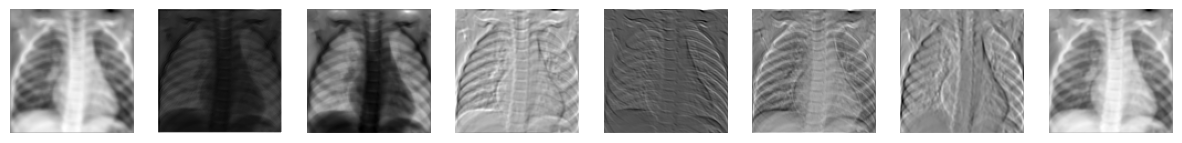

 layer1 → (1, 256, 112, 112)


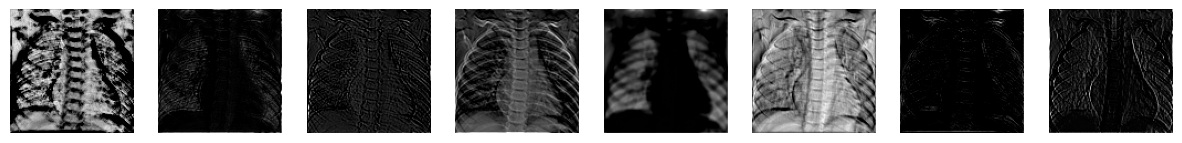

 layer2 → (1, 512, 56, 56)


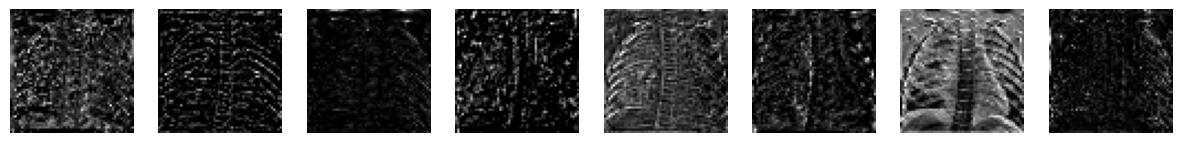

 layer3 → (1, 1024, 28, 28)


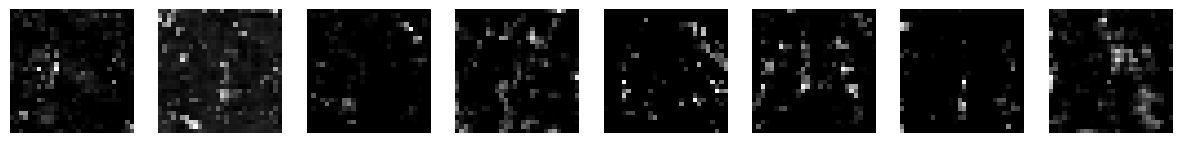

 layer4 → (1, 2048, 14, 14)


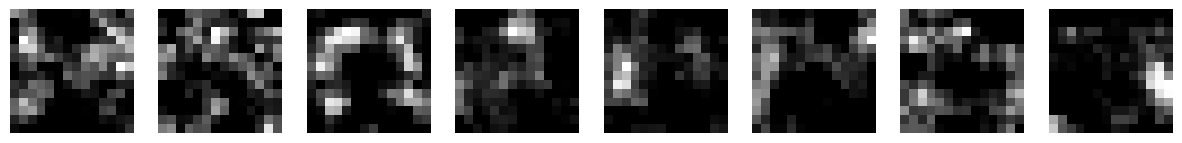

In [44]:
ch_3_sample_image = ch_3_train_dataset[0][0]

layers_dict = dict(ch_3_model.named_children())


def show_feature(name, out, max_channels=8):
    fmap = out.squeeze(0).detach().cpu()
    num = min(max_channels, fmap.shape[0])
    fig, axes = plt.subplots(1, num, figsize=(15,4))

    for i, ax in enumerate(axes if num>1 else [axes]):
        ax.imshow(fmap[i], cmap="gray")
        ax.axis("off")

    print(f" {name} → {tuple(out.shape)}")
    plt.show()


out = ch_3_transform(ch_3_sample_image).unsqueeze(0)
for layer in ["conv1", "layer1", "layer2","layer3","layer4"]:
    out = layers_dict[layer](out)
    show_feature(layer, out)

layer3부터 특징이 뚜렷하지 않으므로 재학습 시점으로 설정한다.

In [ ]:
import torch.nn as nn
import torch.optim as optim

# 출력층 수정
in_features = ch_3_model.fc.in_features
ch_3_model.fc = nn.Linear(in_features=in_features, out_features=2) # 1000 -> 2


# 레이어 학습, 동결 구분
for name, param in ch_3_model.named_parameters():
    if name.startswith(("layer2", "layer3", "layer4", "fc")):
        param.requires_grad = True
    else:
        param.requires_grad = False

# 디바이스
ch_3_model = ch_3_model.to(ch_3_device)

# 손실함수
ch_3_criterion = nn.CrossEntropyLoss()

# 옵티마이저 설정
ch_3_params_to_update=[]
for param in ch_3_model.parameters():
  if param.requires_grad:
    ch_3_params_to_update.append(param)

ch_3_optim = optim.Adam(ch_3_params_to_update, lr=0.0005)

In [46]:
num_epochs = 5

ch_3_train_losses, ch_3_val_losses, ch_3_test_losses = [], [], []
ch_3_train_accuracies, ch_3_val_accuracies, ch_3_test_accuracies = [], [], []

val_flag = False

for epoch in range(num_epochs):
    if val_flag == True:
        break

    ch_3_model.train()
    train_loss = 0.0
    correct = 0
    total = 0

    for Xs, ys in ch_3_train_dataloader:
        
        Xs = Xs.to(ch_3_device)
        ys = ys.to(ch_3_device)

        y_preds = ch_3_model(Xs)
        loss = ch_3_criterion(y_preds, ys)
       
        ch_3_optim.zero_grad()
        loss.backward()
        ch_3_optim.step()

        train_loss += loss.item()

        _, preds = torch.max(y_preds, 1) # 1은 dim을 의미. (value와 indice 반환)
        correct += (preds == ys).sum().item()
        total += ys.size(0)


    ch_3_epoch_train_loss = train_loss / len(ch_3_train_dataloader)
    ch_3_epoch_train_acc = correct / total
    ch_3_train_losses.append(train_loss / len(ch_3_train_dataloader))
    ch_3_train_accuracies.append(ch_3_epoch_train_acc)


    # 검증
    ch_3_model.eval()
    ch_3_val_loss, correct, total = 0.0, 0, 0

    with torch.no_grad():
        for Xs, ys in ch_3_val_dataloader:
            Xs = Xs.to(ch_3_device)
            ys = ys.to(ch_3_device)

            y_preds = ch_3_model(Xs)
            loss = ch_3_criterion(y_preds, ys)
            ch_3_val_loss += loss.item()
        
            _, preds = torch.max(y_preds, 1) # 1은 dim을 의미. (value와 indice 반환)
            correct += (preds == ys).sum().item()
            total += ys.size(0)

            ch_3_epoch_val_loss = ch_3_val_loss / len(ch_3_val_dataloader)
            ch_3_val_losses.append(ch_3_epoch_val_loss)
            
            ch_3_epoch_val_acc = correct / total
            ch_3_val_accuracies.append(ch_3_epoch_val_acc)
            
            if len(ch_3_val_losses) > 1:
                if ch_3_val_losses[-1] > ch_3_val_losses[-2]:
                    val_flag = True


# 테스트
ch_3_model.eval()
ch_3_test_loss, correct, total = 0.0, 0, 0

with torch.no_grad():
    for Xs, ys in ch_3_test_dataloader:
        Xs, ys = Xs.to(device), ys.to(device)
        y_preds = ch_3_model(Xs)
        loss = ch_3_criterion(y_preds, ys)
        ch_3_test_loss += loss.item()

        _, preds = torch.max(y_preds, 1)
        correct += (preds == ys).sum().item()
        total += ys.size(0)


ch_3_epoch_test_loss = ch_3_test_loss / len(ch_3_test_dataloader)
ch_3_epoch_test_acc = correct / total
ch_3_test_losses.append(ch_3_epoch_test_loss)
ch_3_test_accuracies.append(ch_3_epoch_test_acc)


# -------------------
# Logging
# -------------------
print(f"[Epoch {epoch+1}] "
        f"Train Loss: {ch_3_epoch_train_loss:.4f} | "
        f"Train Acc: {ch_3_epoch_train_acc*100:.2f}% | "
        f"Test Loss: {ch_3_epoch_test_loss:.4f} | "
        f"Test Acc: {ch_3_epoch_test_acc*100:.2f}%")


clean_cache()

0.00s - Debugger warning: It seems that frozen modules are being used, which may
0.00s - make the debugger miss breakpoints. Please pass -Xfrozen_modules=off
0.00s - to python to disable frozen modules.
0.00s - Note: Debugging will proceed. Set PYDEVD_DISABLE_FILE_VALIDATION=1 to disable this validation.
0.00s - Debugger warning: It seems that frozen modules are being used, which may
0.00s - make the debugger miss breakpoints. Please pass -Xfrozen_modules=off
0.00s - to python to disable frozen modules.
0.00s - Note: Debugging will proceed. Set PYDEVD_DISABLE_FILE_VALIDATION=1 to disable this validation.
0.00s - Debugger warning: It seems that frozen modules are being used, which may
0.00s - make the debugger miss breakpoints. Please pass -Xfrozen_modules=off
0.00s - to python to disable frozen modules.
0.00s - Debugger warning: It seems that frozen modules are being used, which may
0.00s - Note: Debugging will proceed. Set PYDEVD_DISABLE_FILE_VALIDATION=1 to disable this validation.
0

[Epoch 4] Train Loss: 0.1343 | Train Acc: 95.67% | Test Loss: 1.2897 | Test Acc: 67.15%


## 1채널 모델

In [47]:
# 모델의 주요 레이어 확인
print("[1채널 모델 주요 레이어]")

for n, (name, module) in enumerate(ch_1_model.named_children()):
    print(f"{n}) {name}: {module.__class__.__name__}")

# 입력과 출력층
print("\n[1채널 입력층과 출력층]")
print(f"· 입력층: {ch_1_model.conv1}")
print(f"· 출력층: {ch_1_model.fc}")

[1채널 모델 주요 레이어]
0) conv1: Conv2d
1) bn1: BatchNorm2d
2) relu: ReLU
3) maxpool: MaxPool2d
4) layer1: Sequential
5) layer2: Sequential
6) layer3: Sequential
7) layer4: Sequential
8) avgpool: AdaptiveAvgPool2d
9) fc: Linear

[1채널 입력층과 출력층]
· 입력층: Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
· 출력층: Linear(in_features=2048, out_features=1000, bias=True)


In [48]:
import torch.nn as nn

# 기존 conv1(입력 레이어)의 가중치(3채널)을 1채널화
old_weights = ch_1_model.conv1.weight.data
ch_1_model.conv1 = nn.Conv2d(1, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False) # 시그모이드로 하는 건 여기가 아닌가?
with torch.no_grad():
    ch_1_model.conv1.weight.data = old_weights.mean(dim=1, keepdim=True)


# 출력층 수정
in_features = ch_1_model.fc.in_features
ch_1_model.fc = nn.Linear(in_features=in_features, out_features=2)

In [49]:
# 샘플 이미지 통해 레이어 정하기
ch_1_sample_image = ch_1_train_dataset[0][0].to(ch_1_device)

x = ch_1_transform(ch_1_sample_image).unsqueeze(0)
layers = dict(ch_1_model.named_children())

out = x
for name in ["conv1", "layer1", "layer2","layer3","layer4"]:
    out = layers[name](out)
    show_feature(name, out)

RuntimeError: Input type (MPSFloatType) and weight type (torch.FloatTensor) should be the same

동일하게 layer 2까지 쓰고, layer 3부터 재학습을 실시한다.

단, 기존의 입력층에 해당하는 conv2d의 입력 채널이 3에서 1로 바뀌었기 때문에 재학습이 필요하다.

In [ ]:
# 레이어 학습, 동결 구분
for name, param in ch_1_model.named_parameters():
    if name.startswith(( "conv1", "layer3", "layer4", "fc")): # conv1도 재학습 필요.
        param.requires_grad = True
    else:
        param.requires_grad = False


# 디바이스
ch_1_model = ch_1_model.to(ch_1_device)

# 손실함수
ch_1_criterion = nn.CrossEntropyLoss()

# 옵티마이저 설정
ch_1_params_to_update=[]
for param in ch_1_model.parameters():
  if param.requires_grad:
    ch_1_params_to_update.append(param)

ch_1_optim = optim.Adam(ch_1_params_to_update, lr=0.0005)